## Bayesian estimates of (Mr, [Fe/H], Ar) using SDSS colors and TRILEGAL priors

### speed: from 0.1-0.2 sec/star for full locus resolution to 10 millisec for sparse locus

### (with known Ar: 2D version runs in 4 milisec/star

## LP: this requires a simulated catalog as input?

In [1]:
## automatically reload any modules read below that might have changed (e.g. plots)
%reload_ext autoreload
%matplotlib inline
import sys
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde
# from scipy import interpolate 
from scipy.interpolate import griddata
%autoreload 2
# importing plotting and locus tools: 
sys.path.append('../src')

import LocusTools as lt
import BayesTools as bt
import PlotTools as pt


from dask.distributed import Client

pd.set_option('display.max_columns', None)

In [2]:
try:
    client.shutdown()
    client.close()

except Exception as e:
    print(e)
    pass

name 'client' is not defined


In [3]:
n = 1
mem = str(16*n)+"GB"
print("workers=", str(96//n), "\nmem=", mem)

try:
    client.shutdown()
    client.close()

    client = Client(n_workers=96//n, threads_per_worker=1, memory_limit=mem, 
                dashboard_address=':35863')
except Exception as e: 
    print("Exception raised", e)
    client = Client(n_workers=96//n, threads_per_worker=1, memory_limit=mem, 
                dashboard_address=':35863')

client

workers= 96 
mem= 16GB
Exception raised name 'client' is not defined


/nvme/lovro/miniconda3/envs/photoD-dev/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 35863 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41939 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41939/status,
Dashboard: http://127.0.0.1:41939/status,Workers: 96
Total threads: 96,Total memory: 1.40 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41955,Workers: 96
Dashboard: http://127.0.0.1:41939/status,Total threads: 96
Started: Just now,Total memory: 1.40 TiB
Comm: tcp://127.0.0.1:36547,Total threads: 1
Dashboard: http://127.0.0.1:38269/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:46209,


## LSDB

CPU times: user 1.14 s, sys: 1.17 s, total: 2.31 s
Wall time: 5.48 s


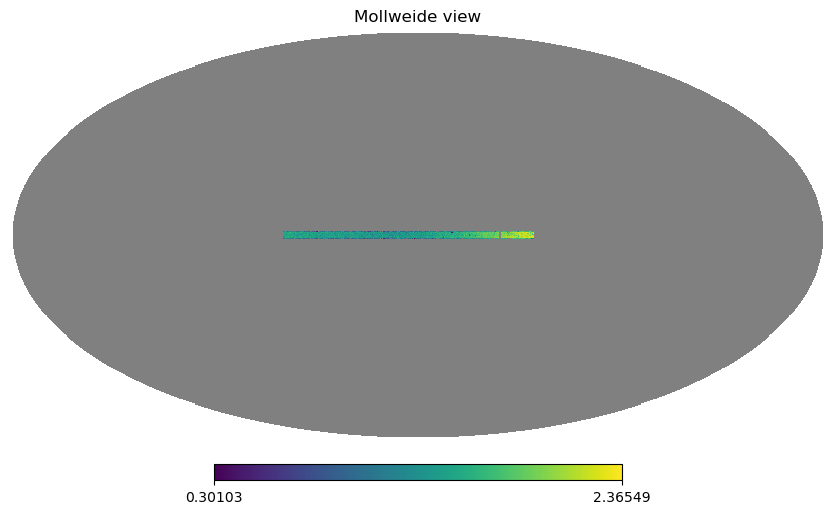

In [32]:
%%time
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch, box_search

"""## read TRILEGAL sim-based data file, augmented with LSST colors 
## the input data are limited to 0.2 < g-i < 3.0 and
## -2.5 < FeH < 0 and Mr > -1.0 and log(g) < 7 and rmag < 26 
sims = lt.readTRILEGALLSST(inTLfile='../data/simCatalog_three_pix_triout_chiTest4.txt', chiTest=True)
sims[0:2]
"""

tril_fn = "/home/lovro/scratch/data/TRILEGAL_hipscat_new_2/trilegal/"
# sims = lsdb.read_hipscat(tril_fn, search_filter=BoxSearch(ra=(340, 350), dec=(-1.26, +1.26)))
sims = lsdb.read_hipscat("/mnt/beegfs/scratch/data/S82_standards/S82_hipscat/")
sims.skymap(lambda df, a: np.log10(len(df)+1), order=9)

### read photometric catalog with stars

In [5]:
def process(df, pix):
    sys.path.append('../src')
    import LocusTools as lt
    # import BayesTools as bt
    import PlotTools as pt
    import importlib
    importlib.reload(lt)
    # importlib.reload(bt)
    importlib.reload(pt)

    # rootname = '/mnt/beegfs/scratch/lovro/temp/hipscat_LSDB_sample'  # TODO: clean this up!
    df=df.rename(columns={"gall": "glon", "galb": "glat", "gc": "comp", 
                          "m_h": "FeH", "av": "Av", "mu0": "DM"}) 
                          # 'gc': 'GC',
                          # "label": "pop"})
    cat = lt.readTRILEGALLSDB(df)
    cat['Mr'] = cat['rmag'] - cat['Ar'] - cat['DM']

    # save original TRILEGAL magnitudes
    for b in ['u', 'g', 'r', 'i', 'z']:  
        cat[b+'magTL'] = cat[b+'mag']
    ## and this is a hack to "fix" TRILEGAL [Fe/H] distribution to be more similar to SDSS measurements
    if (1):
        # shift thin disk stars to lower [Fe/H] by 0.3 dex
        # cat['FeH'] = np.where(cat['GC']==1, cat['FeH']-0.3, cat['FeH'])
        cat['FeH'] = np.where(cat['comp']==1, cat['FeH']-0.3, cat['FeH'])
        # shift halo stars to higher [Fe/H] by 0.1 dex
        # cat['FeH'] = np.where(cat['GC']==3, cat['FeH']+0.1, cat['FeH'])    
        cat['FeH'] = np.where(cat['comp']==3, cat['FeH']+0.1, cat['FeH'])    

    
    ## separate MS/RGs from white dwarfs 
    # catMSRG = cat[cat['pop']<9]
    # catWD = cat[cat['pop']==9]
    # catMSRG = cat[cat['label']<9]
    # catWD = cat[cat['label']==9]
    # print('MSRG:', np.size(catMSRG), 'WD:', np.size(catWD))
    
    # return pd.DataFrame(data=[(len(trilegal), type(trilegal))], columns=['len', 'dtype']) # <--- it is expected that a Pandas is returned
    # return pd.DataFrame(data=[(pix, len(cat))], columns=['HealPix', 'len']) #, columns=['partition']) # <--- it is expected that a Pandas is returned
    # return pd.DataFrame(data=[()], columns=['HealPix', 'len']) #, columns=['partition']) # <--- it is expected that a Pandas is returned
    return cat

In [23]:
%%time 
old_colnames = ['ummed', 'gmmed', 'rmmed', 'immed', 'zmmed', 'umsig', 'gmsig', 'rmsig', 'imsig', 'zmsig']
colnames = ['umag', 'gmag', 'rmag', 'imag', 'zmag', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr']
col_dict=dict(zip(old_colnames, colnames))
col_dict
sims=sims.map_partitions(lambda df: df.rename(columns=col_dict))
sims=sims.map_partitions(lambda df: df.assign(Mr=-99))
sims=sims.map_partitions(lambda df: df.assign(FeH=-99))
sims=sims.map_partitions(lambda df: df.assign(ug=df.umag-df.gmag))
sims=sims.map_partitions(lambda df: df.assign(gr=df.gmag-df.rmag))
sims=sims.map_partitions(lambda df: df.assign(ri=df.rmag-df.imag))
sims=sims.map_partitions(lambda df: df.assign(iz=df.imag-df.zmag))
sims=sims.map_partitions(lambda df: df.assign(ugErr=np.sqrt(df.uErr**2+df.gErr**2)))
sims=sims.map_partitions(lambda df: df.assign(grErr=np.sqrt(df.gErr**2+df.rErr**2)))
sims=sims.map_partitions(lambda df: df.assign(riErr=np.sqrt(df.rErr**2+df.iErr**2)))
sims=sims.map_partitions(lambda df: df.assign(izErr=np.sqrt(df.iErr**2+df.zErr**2)))
sims.compute()

CPU times: user 2.43 s, sys: 1.83 s, total: 4.26 s
Wall time: 7.65 s


,CALIBSTARS,ra,dec,RArms,Decrms,Ntot,Ar,uNobs,umag,ummu,uErr,umrms,umchi2,gNobs,gmag,gmmu,gErr,gmrms,gmchi2,rNobs,rmag,rmmu,rErr,rmrms,rmchi2,iNobs,imag,immu,iErr,imrms,imchi2,zNobs,zmag,zmmu,zErr,zmrms,zmchi2,Norder,Dir,Npix,Mr,ug,gr,ri,iz,ugErr,grErr,riErr,izErr,FeH
_hipscat_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
715281479499776,CALIBSTARS_0891163,43.787097,1.037784,0.0282,0.0282,24,0.256,23,19.544,19.547,0.007,0.044,1.034,22,17.958,17.958,0.004,0.015,0.71,21,17.287,17.288,0.003,0.004,0.302,22,17.024,17.027,0.003,0.014,0.949,23,16.886,16.891,0.004,0.017,0.835,4,0,0,-99,1.586,0.671,0.263,0.138,0.008062,0.005000,0.004243,0.005000,-99
715101011181568,CALIBSTARS_0891187,43.828101,1.040223,0.4066,0.4066,47,0.253,24,18.47,18.469,0.005,0.028,1.098,24,17.38,17.378,0.004,0.019,1.014,23,16.973,16.973,0.003,0.013,0.944,23,16.812,16.81,0.003,0.009,0.627,24,16.748,16.75,0.004,0.011,0.611,4,0,0,-99,1.09,0.407,0.161,0.064,0.006403,0.005000,0.004243,0.005000,-99
714770441306112,CALIBSTARS_0891200,43.831573,1.024147,0.0315,0.0315,25,0.254,8,22.873,22.887,0.136,0.15,0.342,24,20.266,20.267,0.006,0.022,0.76,23,18.816,18.814,0.004,0.009,0.45,25,18.018,18.023,0.003,0.015,0.829,25,17.567,17.566,0.005,0.018,0.706,4,0,0,-99,2.607,1.45,0.798,0.451,0.136132,0.007211,0.005000,0.005831,-99
712559007105024,CALIBSTARS_0891206,43.870259,0.983584,0.0259,0.0259,25,0.253,25,21.136,21.113,0.019,0.09,0.76,25,19.771,19.775,0.005,0.019,0.586,25,19.245,19.242,0.004,0.016,0.742,25,19.03,19.033,0.004,0.017,0.784,24,18.919,18.924,0.01,0.036,0.787,4,0,0,-99,1.365,0.526,0.215,0.111,0.019647,0.006403,0.005657,0.010770,-99
713770364043264,CALIBSTARS_0891209,43.884348,1.028387,0.0506,0.0506,25,0.251,25,19.421,19.411,0.007,0.036,1.13,25,17.74,17.738,0.004,0.021,0.949,25,17.089,17.09,0.003,0.011,0.764,24,16.85,16.848,0.003,0.016,1.029,23,16.731,16.73,0.004,0.014,0.744,4,0,0,-99,1.681,0.651,0.239,0.119,0.008062,0.005000,0.004243,0.005000,-99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13834351349564702720,CALIBSTARS_0218913,316.124689,-0.984808,0.0322,0.0322,16,0.175,12,21.903,21.876,0.058,0.182,0.693,14,21.165,21.165,0.013,0.032,0.688,15,20.899,20.895,0.013,0.036,0.57,16,20.793,20.768,0.017,0.051,0.701,10,20.744,20.665,0.066,0.158,0.791,4,0,3071,-99,0.738,0.266,0.106,0.049,0.059439,0.018385,0.021401,0.068154,-99
13834353321231515648,CALIBSTARS_0218915,316.057052,-0.95856,0.0349,0.0349,15,0.185,9,22.975,22.955,0.138,0.163,0.371,15,21.535,21.545,0.017,0.071,0.908,14,21.02,21.002,0.015,0.055,1.019,15,20.82,20.774,0.017,0.068,1.157,13,20.602,20.582,0.054,0.096,0.502,4,0,3071,-99,1.44,0.515,0.2,0.218,0.139043,0.022672,0.022672,0.056613,-99
13834351427796860928,CALIBSTARS_0218917,316.133306,-0.971373,0.041,0.041,16,0.174,3,24.789,24.878,0.611,0.09,0.095,13,22.356,22.341,0.034,0.075,0.577,16,21.081,21.081,0.015,0.061,0.923,16,20.525,20.51,0.013,0.057,1.156,13,20.048,20.061,0.034,0.2,1.482,4,0,3071,-99,2.433,1.275,0.556,0.477,0.611945,0.037162,0.019849,0.036401,-99


In [7]:
%%time 
print(np.min(sims['Mr']).compute(), np.max(sims['Mr']).compute())   # priors only support Mr<15; need to rerun priors
print(np.min(sims['glon']).compute(), np.max(sims['glon']).compute())
print(np.min(sims['glat']).compute(), np.max(sims['glat']).compute())

-99 -99


KeyError: 'glon'

### read stellar locus parametrization

In [7]:
LSSTlocus = lt.LSSTsimsLocus(fixForStripe82=False)
## select the color range where we expect main sequence and red giants
# this fails, need to rerun priors for Mr>15
# OKlocus = LSSTlocus[(LSSTlocus['gi']>0.2)&(LSSTlocus['gi']<3.8)]  # 3.8 to get beyond MrMax in sims
OKlocus = LSSTlocus[(LSSTlocus['gi']>0.2)&(LSSTlocus['gi']<3.55)]   # gives MrMax < 15 (rerun priors!)
OKlocus[0:2]

Mr,FeH,ug,gr,ri,iz,zy,gi
float64,float64,float64,float64,float64,float64,float64,float64
-1.0,-2.5,1.3805,0.578,0.265,0.1681,0.0803,0.843
-0.99,-2.5,1.3793,0.5776,0.2648,0.1679,0.0802,0.8424


In [8]:
print(np.min(LSSTlocus['Mr']), np.min(OKlocus['Mr']))
print(np.max(LSSTlocus['Mr']), np.max(OKlocus['Mr']))

-1.0 -1.0
28.0 14.58


### process data...

In [9]:
### 
catalog = sims
fitColors = ('ug', 'gr', 'ri', 'iz')  
priorsRootName = '../data/TRILEGALpriors/priors'
if (1):
    # maximum resolution version
    locusData = OKlocus  
    outfile = '../data/simCatalog_three_pix_triout_chiTest4_BayesEstimates3D.txt'
else:
    ## subsample Mr and FeH grids (linear speed-up but somewhat lower accuracy)
    kMr = 10
    kFeH = 2 
    locusData = lt.subsampleLocusData(OKlocus, kMr, kFeH)
    outfile = '../data/simCatalog_three_pix_triout_chiTest4_BayesEstimates3Dsparse10_2.txt'

In [10]:
### make 3D locus list with three ArGrid limits and resolutions
timeStart = !date +%s  
ArGridList, locus3DList = lt.get3DmodelList(locusData, fitColors)
timeEnd = !date +%s  
runTime = int(timeEnd[0])-int(timeStart[0])
print('Made model locus3D list in', runTime,'seconds.')

Made model locus3D list in 65 seconds.


In [15]:
flag1 = (sims['Mr']>4.5)&(sims['Mr']<4.6)&(sims['FeH']>-1.0)&(sims['FeH']<-0.7)&(sims['rmag']>21.0)&(sims['rmag']<22.0)
flag2 = (sims['Ar']>0.0)&(sims['Ar']<0.40)
catalog = sims[flag1&flag2].compute()
len(catalog)

KeyError: 'Mr'

In [25]:
%%time
catalog=sims.compute()

CPU times: user 1.89 s, sys: 1.48 s, total: 3.37 s
Wall time: 6.73 s


In [26]:
import importlib
importlib.reload(lt)
importlib.reload(bt)
importlib.reload(pt)


# catalog = sims.compute()
iStart = 0  #  
iEnd = -1    # if <0: do all stars
myStars = [0, 1, 2] # , 3, 4, 10, 100, 195, 100592, 710592, 1000, 10000]  # for method illustration, make plots for these stars 
# myStars = [] # no plots when measuring speed
verb=True #True

### TESTS (set to False to bypass)
if True: 
    iStart = 0 # 100592  # for testing option restrictLocus=True in bt.makeBayesEstimates3D
    #iStart = 1  # for testing option restrictLocus=True in bt.makeBayesEstimates3D
    iEnd = iStart + 1
    # myStars = [100592, 100593, 100594, 100595, 100596] 
    myStars = [0, 1, 2, 3, 4]
    #myStars = [100592] 
    outfile = '../data/simCatalog_three_pix_triout_chiTest4_BayesEstimates3Ddiscard.txt'
    ############

bt.makeBayesEstimates3D(catalog.iloc[myStars], fitColors, locusData, locus3DList, ArGridList, priorsRootName, outfile, 
                        iStart, iEnd, myStars, verbose=verb)

Mr1d= -1.0 14.58 1559
MrBright, MrFaint= -1.0 14.58
working on star 0


/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/../src/BayesTools.py:1070: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  catalog['chi2min'][i] = np.min(chi2map)
/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/../src/BayesTools.py

KeyError: 0

In [ ]:
import importlib
importlib.reload(lt)
importlib.reload(bt)
importlib.reload(pt)


catalog = sims.compute()
iStart = 0  #  
iEnd = -1    # if <0: do all stars
myStars = [0, 1, 2, 3, 4, 10, 100, 195, 100592, 710592, 1000, 10000]  # for method illustration, make plots for these stars 
myStars = [] # no plots when measuring speed
verb=True #True

### TESTS (set to False to bypass)
if False: 
    iStart = 100592  # for testing option restrictLocus=True in bt.makeBayesEstimates3D
    #iStart = 1  # for testing option restrictLocus=True in bt.makeBayesEstimates3D
    iEnd = iStart + 1
    myStars = [100592, 100593, 100594, 100595, 100596] 
    #myStars = [0, 1, 2, 3, 4]
    #myStars = [100592] 
    outfile = '../data/simCatalog_three_pix_triout_chiTest4_BayesEstimates3Ddiscard.txt'
    ############

timeStart = !date +%s  
bt.makeBayesEstimates3D(catalog, fitColors, locusData, locus3DList, ArGridList, priorsRootName, outfile, 
                        iStart, iEnd, myStars, verbose=verb)

# 2D version, where prior for Ar is set to the true value for each star
# bt.makeBayesEstimates2D(catalog, fitColors, OKlocus, priorsRootName, outfile, iStart, iEnd, myStars, verbose=False)
timeEnd = !date +%s  
runTime = int(timeEnd[0])-int(timeStart[0])
print('Finished in', runTime, 'seconds.')

Mr1d= -1.0 14.58 1559
MrBright, MrFaint= -1.0 14.58
working on star 0


/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/../src/BayesTools.py:1070: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  catalog['chi2min'][i] = np.min(chi2map)
/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/../src/BayesTools.py

In [17]:
catalog

,CALIBSTARS,ra,dec,RArms,Decrms,Ntot,Ar,uNobs,ummed,ummu,umsig,umrms,umchi2,gNobs,gmmed,gmmu,gmsig,gmrms,gmchi2,rNobs,rmmed,rmmu,rmsig,rmrms,rmchi2,iNobs,immed,immu,imsig,imrms,imchi2,zNobs,zmmed,zmmu,zmsig,zmrms,zmchi2,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
715281479499776,CALIBSTARS_0891163,43.787097,1.037784,0.0282,0.0282,24,0.256,23,19.544,19.547,0.007,0.044,1.034,22,17.958,17.958,0.004,0.015,0.71,21,17.287,17.288,0.003,0.004,0.302,22,17.024,17.027,0.003,0.014,0.949,23,16.886,16.891,0.004,0.017,0.835,4,0,0
715101011181568,CALIBSTARS_0891187,43.828101,1.040223,0.4066,0.4066,47,0.253,24,18.47,18.469,0.005,0.028,1.098,24,17.38,17.378,0.004,0.019,1.014,23,16.973,16.973,0.003,0.013,0.944,23,16.812,16.81,0.003,0.009,0.627,24,16.748,16.75,0.004,0.011,0.611,4,0,0
714770441306112,CALIBSTARS_0891200,43.831573,1.024147,0.0315,0.0315,25,0.254,8,22.873,22.887,0.136,0.15,0.342,24,20.266,20.267,0.006,0.022,0.76,23,18.816,18.814,0.004,0.009,0.45,25,18.018,18.023,0.003,0.015,0.829,25,17.567,17.566,0.005,0.018,0.706,4,0,0
712559007105024,CALIBSTARS_0891206,43.870259,0.983584,0.0259,0.0259,25,0.253,25,21.136,21.113,0.019,0.09,0.76,25,19.771,19.775,0.005,0.019,0.586,25,19.245,19.242,0.004,0.016,0.742,25,19.03,19.033,0.004,0.017,0.784,24,18.919,18.924,0.01,0.036,0.787,4,0,0
713770364043264,CALIBSTARS_0891209,43.884348,1.028387,0.0506,0.0506,25,0.251,25,19.421,19.411,0.007,0.036,1.13,25,17.74,17.738,0.004,0.021,0.949,25,17.089,17.09,0.003,0.011,0.764,24,16.85,16.848,0.003,0.016,1.029,23,16.731,16.73,0.004,0.014,0.744,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13834351349564702720,CALIBSTARS_0218913,316.124689,-0.984808,0.0322,0.0322,16,0.175,12,21.903,21.876,0.058,0.182,0.693,14,21.165,21.165,0.013,0.032,0.688,15,20.899,20.895,0.013,0.036,0.57,16,20.793,20.768,0.017,0.051,0.701,10,20.744,20.665,0.066,0.158,0.791,4,0,3071
13834353321231515648,CALIBSTARS_0218915,316.057052,-0.95856,0.0349,0.0349,15,0.185,9,22.975,22.955,0.138,0.163,0.371,15,21.535,21.545,0.017,0.071,0.908,14,21.02,21.002,0.015,0.055,1.019,15,20.82,20.774,0.017,0.068,1.157,13,20.602,20.582,0.054,0.096,0.502,4,0,3071
13834351427796860928,CALIBSTARS_0218917,316.133306,-0.971373,0.041,0.041,16,0.174,3,24.789,24.878,0.611,0.09,0.095,13,22.356,22.341,0.034,0.075,0.577,16,21.081,21.081,0.015,0.061,0.923,16,20.525,20.51,0.013,0.057,1.156,13,20.048,20.061,0.034,0.2,1.482,4,0,3071


In [17]:
# for processed stars
if (iEnd < iStart):
    iStart = 0
    iEnd = np.size(catalog)
#simsP = sims[iStart:iEnd]
simsP = catalog[iStart:iEnd]
simsP['dMr'] = simsP['Mr'] - simsP['MrEst']
simsP['dMrNorm'] = simsP['dMr'] / simsP['MrEstUnc'] 
simsP['dFeH'] = simsP['FeH'] - simsP['FeHEst']
simsP['dFeHNorm'] = simsP['dFeH'] / simsP['FeHEstUnc'] 
simsP['dAr'] = simsP['Ar'] - simsP['ArEst']
simsP['dArNorm'] = simsP['dAr'] / simsP['ArEstUnc'] 
print('sample size:', np.size(simsP))
print('Mr  FeH  Ar:')
print('median uncertainty:', np.median(simsP['MrEstUnc']), np.median(simsP['FeHEstUnc']), np.median(simsP['ArEstUnc']))
print('median error:', np.median(simsP['dMr']), np.median(simsP['dFeH']), np.median(simsP['dAr']))
print('std for chi:', np.std(simsP['dMrNorm']), np.std(simsP['dFeHNorm']), np.std(simsP['dArNorm']))

sample size: 3
Mr  FeH  Ar:
median uncertainty: 0.12644813662450566 0.20159497438827056 0.036069045620680744
median error: 0.058641887224142764 -0.20798460059837276 0.01783731373681488
std for chi: 0.46944880719590537 0.40334631619079403 0.4352283157198634


In [11]:
# SPEED TEST (with all stars):
# 3D finished in 253673 seconds: 0.312 sec/star or 11550 star/hr (or 4 days for a million stars)
# 3D with 10-2 sparse models: 8657 seconds, or ~30 times faster (10 milisec/star)
# 2D: 

In [12]:
### component speed tests: 1000 stars (so sec -> milisec)
# 0) full computation: 161 sec  (3 sec for 2D)
# 1) chi2 computation: 22 sec  
# 2) likeGrid computation: 16 sec (for simple exp computation)
# 3) priors: 15 sec 
# 4) posterior: 7 sec (for posterior = prior * likelihood)
# 5) marginal distributions and stats: 8 sec 
# 6) writing: <1 sec 
# 7) initial pre-loop setup: 4 sec
##
## tests of subsampling: linear scaling with the # of grid points
## kSubsample  makeLocus  total runtime
#    1  1         97          128
#    1  2         47           63
#    2  1         49           64
#    5  1         20           26 
#    5  2          9           14
#   10  2          5            8 

In [13]:
# interesting stars for further investigation and illustration
# i=195 tri-modal posterior for Ar 
# i=100592 nice turn-off with nice parameter covariances - rerun at higher resolution (no subsampling)

In [ ]:
def showQplot(postCube, Mr1d, FeH1d, Ar1d, md, xLab='FeH', yLab='Q', x0=-99, y0=-99, z0=-99, logScale=False, cmap='Blues'):

    def oneImage(ax, image, extent, title, showTrue, x0, y0, origin, logScale=True, cmap='Blues'):
        im = image/image.max()
        if (logScale):
            cmap = ax.imshow(im.T,
               origin=origin, aspect='auto', extent=extent,
               cmap=cmap, norm=LogNorm(im.max()/100, vmax=im.max()))
        else:
            cmap = ax.imshow(im.T, origin='upper', aspect='auto', extent=extent, cmap=cmap)
        ax.set_title(title)
        if (showTrue):
            ax.scatter(x0, y0, s=150, c='red', alpha=0.3) 
            ax.scatter(x0, y0, s=40, c='yellow', alpha=0.3) 
        return cmap

 
    # unpack metadata
    xMin = md[0]  # FeH
    xMax = md[1]
    yMin = md[3]  # Mr
    yMax = md[4]
    zMin = 0      # Ar
    zMax = Ar1d[-1]
       
    #### make 3 marginal (summed) 2-D distributions and 3 1-D marginal distributions 
    # grid steps
    dFeH = FeH1d[1]-FeH1d[0]
    dMr = Mr1d[1]-Mr1d[0]
    dAr = Ar1d[1]-Ar1d[0]
    
    # 1-D marginal distributions
    margMr, margFeH, margAr = getMargDistr3D(postCube, dMr, dFeH, dAr) 

    # 2-D marginal distributions
    # Mr vs. FeH
    im1 = np.sum(postCube, axis=(2))
    # Ar vs. FeH
    im2 = np.sum(postCube, axis=(1))
    # Ar vs. Mr
    im3 = np.sum(postCube, axis=(0))
        
    showTrue = False
    if ((x0>-99)&(y0>-99)):
        showTrue = True
        
    ### plot  
    fig, axs = plt.subplots(3,3,figsize=(12,12))
    fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95, bottom=0.12, top=0.95)

    
    # row 1: marginal FeH
    myExtent=[xMin, xMax, yMin, yMax]
    axs[0,0].plot(FeH1d, margFeH, 'r', lw=3)
    axs[0,0].plot([x0, x0], [0, 1.1*np.max(margFeH)], '--k', lw=1)
    axs[0,0].set(xlabel='FeH', ylabel='p(FeH)')
    axs[0,1].set_axis_off()
    axs[0,2].set_axis_off()
  
    # row 2: im1 and marginal Mr
    myExtent=[xMin, xMax, yMin, yMax]
    cmap = oneImage(axs[1,0], im1, myExtent, '', showTrue, x0, y0, origin='upper', logScale=logScale)
    axs[1,0].set(xlabel='FeH', ylabel='Mr')
    axs[1,1].plot(Mr1d, margMr, 'r', lw=3)
    axs[1,1].plot([y0, y0], [0, 1.1*np.max(margMr)], '--k', lw=1)
    axs[1,1].set(xlabel='Mr', ylabel='p(Mr)')
    axs[1,2].set_axis_off()

    # row 3: im2, im3, and marginal Ar
    myExtent=[xMin, xMax, zMin, zMax]
    cmap = oneImage(axs[2,0], im2, myExtent, '', showTrue, x0, z0, origin='lower', logScale=logScale)
    axs[2,0].set(xlabel='FeH', ylabel='Ar')
    myExtent=[yMax, yMin, zMin, zMax]
    cmap = oneImage(axs[2,1], im3, myExtent, '', showTrue, y0, z0, origin='lower', logScale=logScale)
    axs[2,1].set(xlabel='Mr', ylabel='Ar')
    axs[2,2].plot(Ar1d, margAr, 'r', lw=3)
    axs[2,2].plot([z0, z0], [0, 1.1*np.max(margAr)], '--k', lw=1)
    axs[2,2].set(xlabel='Ar', ylabel='p(Ar)')

    
    cax = fig.add_axes([0.84, 0.1, 0.1, 0.75])
    cax.set_axis_off()
    #cb = fig.colorbar(cmap, ax=cax)
    #if (logScale):
        #cb.set_label("density on log scale")
    #else:
        #cb.set_label("density on linear scale")

    #for ax in axs.flat:
        # ax.set(xlabel=xLab, ylabel=yLab)
        # print('pero')
        
    plt.savefig('../plots/cornerPlot3.png')
    plt.show()
     


In [ ]:
# postCube, Mr1d, FeH1d, Ar1d

In [18]:
print(postCube.shape, FeH1d.shape, Mr1d.shape, Ar1d.shape)

(51, 1559, 26) (51,) (1559,) (26,)


In [102]:
def getQmap(cube, FeH1d, Mr1d, Ar1d):
    Smax = -1
    # interpolate 3D cube(FeH, Mr, Ar) onto Qr=Mr+Ar vs. FeH 2D grid 
    Qmap = 0*cube[:,:,0]
    # Q grid, same size as Mr1d array 
    Qr1d = np.linspace(np.min(Mr1d), (np.max(Ar1d)+np.max(Mr1d)), np.size(Mr1d))
    for i in range(0,np.size(FeH1d)):
        for j in range(0,np.size(Qr1d)):
            # summation
            Ssum = 0.0
            for k in range(0,np.size(Ar1d)):
                Mr = Qr1d[j] - Ar1d[k]
                # now need to get the value of index for this Mr
                jk = np.int((Mr-Mr1d[0])/(Mr1d[1]-Mr1d[0])) 
                if ((jk>=0)&(jk<np.size(Mr1d))):
                    Ssum += cube[i,jk,k]
            Qmap[i,j] = Ssum
    return Qmap, Qr1d

In [103]:
Qmap, Qr1d = getQmap(postCube, FeH1d, Mr1d, Ar1d)

In [104]:
FeHmin = np.min(FeH1d)
FeHmax = np.max(FeH1d)
FeHNpts = FeH1d.size  
QrFaint = np.max(Qr1d)
QrBright = np.min(Qr1d)
QrNpts = Qr1d.size 
mdQ = np.array([FeHmin, FeHmax, FeHNpts, QrFaint, QrBright, QrNpts])

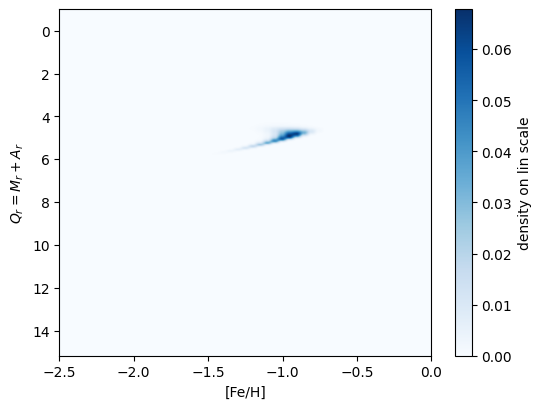

In [105]:
pt.showFlat2Dmap(Qmap, mdQ, xLabel='[Fe/H]', yLabel='$Q_r = M_r + A_r$')